# 初始设置

导入必需的库。
convlstm的实现来自https://github.com/ndrplz/ConvLSTM_pytorch

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import glob
from convlstm import ConvLSTM

# 数据集处理
创建自定义的数据加载器。

In [2]:
class ViolenceDataset(Dataset):
    def __init__(self, pose_paths, change_paths, labels):
        """
        参数:
            pose_paths (list): 包含所有骨架 .npy 文件的完整路径列表
            change_paths (list): 包含所有帧差 .npy 文件的完整路径列表 (必须与 pose_paths 一一对应)
            labels (list): 对应的标签列表 (1 代表暴力, 0 代表非暴力)
        """
        self.pose_paths = pose_paths
        self.change_paths = change_paths
        self.labels = labels
        
        # 确保两个模态的数据量和标签量一致
        assert len(self.pose_paths) == len(self.change_paths) == len(self.labels), \
            f"数据对齐错误: Pose文件数={len(self.pose_paths)}, Change文件数={len(self.change_paths)}, 标签数={len(self.labels)}"

    def __len__(self):
        return len(self.pose_paths)

    def __getitem__(self, idx):
        # 直接通过完整路径加载数据，.npy文件里已经是 (Frames, H, W, C) 的格式
        pose_data = np.load(self.pose_paths[idx])
        change_data = np.load(self.change_paths[idx])
        
        # 转换为 PyTorch 格式 (T, C, H, W)
        pose_data = torch.from_numpy(pose_data).permute(0, 3, 1, 2).float()
        change_data = torch.from_numpy(change_data).permute(0, 3, 1, 2).float()
        
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        return pose_data, change_data, label

返回两个文件夹内共有的.npy文件列表。

In [3]:
def get_aligned_paths(pose_dir, change_dir):
    """
    读取两个对应的文件夹，通过文件名匹配确保数据一一对应
    """
    # 获取文件名（不带路径），用于求交集
    pose_files = {f for f in os.listdir(pose_dir) if f.endswith('.npy')}
    change_files = {f for f in os.listdir(change_dir) if f.endswith('.npy')}
    
    # 取交集，防止某个视频只提取了 pose 没提取 change
    common_files = sorted(list(pose_files & change_files))
    
    if len(common_files) < len(pose_files):
        print(f"警告: {pose_dir} 中有 {len(pose_files)-len(common_files)} 个文件无法在 {change_dir} 中找到对应项，将被忽略。")
    
    # 生成完整路径列表
    pose_paths = [os.path.join(pose_dir, f) for f in common_files]
    change_paths = [os.path.join(change_dir, f) for f in common_files]
    
    return pose_paths, change_paths

一键创建 DataLoaders。

In [4]:
def create_dataloaders(data_root, batch_size=8, test_size=0.2, num_workers=4):
    """
    参数:
        data_root: 数据集根目录
    """
    # 定义子文件夹路径
    dirs = {
        "fight_pose": os.path.join(data_root, "fights_pose_npy"),
        "fight_change": os.path.join(data_root, "fights_change_npy"),
        "nofight_pose": os.path.join(data_root, "noFights_pose_npy"),
        "nofight_change": os.path.join(data_root, "noFights_change_npy"),
    }

    # 1. 获取配对的文件路径
    fight_p, fight_c = get_aligned_paths(dirs["fight_pose"], dirs["fight_change"])
    nofight_p, nofight_c = get_aligned_paths(dirs["nofight_pose"], dirs["nofight_change"])
    
    # 2. 生成标签
    fight_y = [1] * len(fight_p)
    nofight_y = [0] * len(nofight_p)
    
    # 3. 合并
    all_p = fight_p + nofight_p
    all_c = fight_c + nofight_c
    all_y = fight_y + nofight_y
    
    print(f"Dataset summary: Total samples: {len(all_y)} (Fight: {len(fight_y)}, NoFight: {len(nofight_y)})")

    # 4. 划分训练集和验证集
    train_p, val_p, train_c, val_c, train_y, val_y = train_test_split(
        all_p, all_c, all_y, 
        test_size=test_size, 
        random_state=42, 
        stratify=all_y # 保证验证集正负样本比例一致
    )

    # 5. 创建 Dataset 实例
    train_ds = ViolenceDataset(train_p, train_c, train_y)
    val_ds = ViolenceDataset(val_p, val_c, val_y)

    # 6. 创建 DataLoader
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader

# 网络架构

In [5]:
class ViolenceDetector(nn.Module):
    def __init__(self, num_frames=50, height=100, width=100):
        super(ViolenceDetector, self).__init__()
        self.num_frames = num_frames
        
        # --- 配置 ---
        self.fusion_channels = 9 
        
        # ==========================================
        # 1. Pose/RGB Pipeline (已替换为 MobileNetV2)
        # ==========================================
        # 加载预训练的 MobileNetV2
        # pretrained=True 让模型自带识别形状的能力，对骨架图非常有效
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.pose_backbone = mobilenet.features

        # --- 新增：冻结参数 ---
        for param in self.pose_backbone.parameters():
            param.requires_grad = False
        
        # 适配层 (Adapter)：
        # MobileNetV2 的输出是 (Batch, 1280, H/32, W/32)
        # 我们需要把它变成 (Batch, 9, H, W) 才能和下面的 Change 流相加
        self.pose_adapter = nn.Sequential(
            nn.Conv2d(1280, self.fusion_channels, kernel_size=1), # 降维: 1280 -> 9
            nn.BatchNorm2d(self.fusion_channels),
            nn.ReLU(),
            # 关键：因为 MobileNet 把图片变小了 (100x100 -> 4x4)，必须插值放大回去
            nn.Upsample(size=(height, width), mode='bilinear', align_corners=False) 
        )
        
        # ==========================================
        # 2. Change Pipeline (保持不变)
        # ==========================================
        self.change_convlstm = ConvLSTM(input_dim=3, 
                                        hidden_dim=self.fusion_channels, 
                                        kernel_size=(3, 3), 
                                        num_layers=1, 
                                        batch_first=True, 
                                        bias=True, 
                                        return_all_layers=False)
        
        # --- 3. Temporal Aggregation (保持不变) ---
        self.agg_convlstm = ConvLSTM(input_dim=self.fusion_channels, 
                                     hidden_dim=32, 
                                     kernel_size=(3, 3), 
                                     num_layers=1, 
                                     batch_first=True, 
                                     bias=True, 
                                     return_all_layers=False)
        
        # --- 4. Post-processing (保持不变) ---
        self.post_conv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # --- 5. Classification Head (保持不变) ---
        # --- 修改分类头，加入 Dropout ---
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # <--- 新增：丢弃 50% 的神经元
            nn.Linear(128, 16),
            nn.ReLU(),
            nn.Dropout(0.2),  # <--- 新增：丢弃 20% 的神经元
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, pose_seq, change_seq):
        b, t, c, h, w = pose_seq.size()

        # ===========================
        # 1. Pose/RGB Path Processing (修改后)
        # ===========================
        # 将 Batch 和 Time 维度合并，让 CNN 一次处理所有帧
        pose_reshaped = pose_seq.view(b * t, c, h, w)
        
        # MobileNetV2 提取特征
        # 输入: (B*T, 3, 100, 100) -> 输出: (B*T, 1280, 4, 4)
        features = self.pose_backbone(pose_reshaped) 
        
        # 适配层调整: 降维并放大回 100x100
        # 输出: (B*T, 9, 100, 100)
        rgb_feat = self.pose_adapter(features)
        
        # 恢复时间维度，准备给 ConvLSTM 或 融合
        rgb_feat = rgb_feat.view(b, t, self.fusion_channels, h, w)

        # ===========================
        # 2. Change Path Processing (保持不变)
        # ===========================
        change_out_list, _ = self.change_convlstm(change_seq)
        change_feat = change_out_list[0] 
        change_feat = torch.tanh(change_feat)

        # ===========================
        # 3. Fusion (Add) (保持不变)
        # ===========================
        # 现在 rgb_feat 和 change_feat 都是 (B, T, 9, 100, 100)，可以直接相加
        fused_feat = rgb_feat + change_feat

        # ===========================
        # 4. Temporal Aggregation (保持不变)
        # ===========================
        _, last_states = self.agg_convlstm(fused_feat)
        h_agg = last_states[0][0] 

        # ===========================
        # 5. Classification (保持不变)
        # ===========================
        out = self.post_conv(h_agg) 
        out = self.gap(out)         
        predictions = self.classifier(out) 
        
        return predictions

# 训练过程
配置与辅助函数定义。

In [6]:
# --- 配置参数 ---
DATA_ROOT = "../data/RWF2000" 
train_loader, val_loader = create_dataloaders(DATA_ROOT, batch_size=16)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "./checkpoints-v2.1"

# 确保保存路径存在
os.makedirs(SAVE_DIR, exist_ok=True)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 使用 tqdm 包装 loader，显示进度条
    loop = tqdm(loader, desc="Training", leave=False)
    
    for batch_idx, (pose, change, labels) in enumerate(loop):
        # 移动数据到 GPU
        # 输入维度: (B, T, C, H, W)
        pose = pose.to(device)
        change = change.to(device)
        # 标签维度调整: (B) -> (B, 1) 以匹配模型输出
        labels = labels.to(device).unsqueeze(1) 
        
        # 1. 前向传播
        outputs = model(pose, change) # -> (B, 1)
        loss = criterion(outputs, labels)
        
        # 2. 反向传播与优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 3. 统计指标
        predicted = (outputs > 0.5).float() # 阈值 0.5
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
        # 4. 实时更新进度条上的 Loss 和 Acc
        loop.set_postfix(loss=loss.item(), acc=correct/total)
        
    return running_loss / len(loader), correct / total

def validate(model, loader, criterion, device):
    model.eval() # 切换到评估模式
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad(): # 验证阶段不需要计算梯度
        loop = tqdm(loader, desc="Validation", leave=False)
        for pose, change, labels in loop:
            pose = pose.to(device)
            change = change.to(device)
            labels = labels.to(device).unsqueeze(1)
            
            outputs = model(pose, change)
            loss = criterion(outputs, labels)
            
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
            loop.set_postfix(loss=loss.item(), acc=correct/total)
            
    return running_loss / len(loader), correct / total

Dataset summary: Total samples: 2000 (Fight: 1000, NoFight: 1000)


初始化模型与优化器。

In [7]:
# 1. 初始化模型
print(f"Initializing model on {DEVICE}...")
model = ViolenceDetector(num_frames=50).to(DEVICE)

# 2. 定义损失函数
criterion = nn.BCELoss() # 二分类交叉熵损失

Initializing model on cuda...


/home/jovyan/envs/fightingDetection/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jovyan/envs/fightingDetection/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


训练。

In [8]:
# ==========================================
# Phase 2: Fine-tuning (第二阶段：微调)
# ==========================================

# --- 0. 路径配置 (新增修改) ---
# 从旧目录读取 (Checkpoint 2.0)
LOAD_DIR = "./checkpoints-v2.0" 
# 写入新目录 (Checkpoint 2.1)


# 确保新目录存在
os.makedirs(SAVE_DIR, exist_ok=True)

# --- 1. 微调配置参数 ---
FINE_TUNE_EPOCHS = 20   # 再跑 20 轮
FINE_TUNE_LR = 1e-5     # 学习率降为 1e-5 (原为 1e-4)
WEIGHT_DECAY = 1e-4     # L2 正则化系数

print(f"{'-'*60}")
print(f"Starting Phase 2: Fine-tuning...")
print(f" > Reading weights from: {LOAD_DIR}")
print(f" > Saving models to:     {SAVE_DIR}")

# --- 2. 加载 Phase 1 的最佳权重 (从 LOAD_DIR) ---
best_model_path = os.path.join(LOAD_DIR, "best_model.pth")

if os.path.exists(best_model_path):
    print(f"1. Loading best model from: {best_model_path}")
    checkpoint_data = torch.load(best_model_path)
    model.load_state_dict(checkpoint_data)
    print("   Model weights loaded successfully.")
else:
    print(f"   [WARNING] {best_model_path} not found! Using current model weights.")

# --- 3. 解冻 MobileNetV2 骨干网络 ---
print("2. Unfreezing MobileNetV2 backbone parameters...")
for param in model.pose_backbone.parameters():
    param.requires_grad = True

# --- 4. 重新定义优化器 ---
print(f"3. Re-initializing Optimizer: LR={FINE_TUNE_LR}, Weight Decay={WEIGHT_DECAY}")
optimizer = optim.Adam(model.parameters(), lr=FINE_TUNE_LR, weight_decay=WEIGHT_DECAY)

# --- 5. 准备历史数据 ---
# 这里的逻辑是接续之前的图表，如果你之前清空了变量，这里会重新开始记录
if 'train_losses' not in locals():
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    history_start_epoch = 0
    best_val_acc = 0.0
else:
    history_start_epoch = len(train_losses)
    if 'best_val_acc' not in locals(): best_val_acc = 0.0
    print(f"   Continuing from epoch {history_start_epoch} (History preserved).")

print(f"{'-'*60}")

# --- 6. 开始微调循环 ---
for epoch in range(FINE_TUNE_EPOCHS):
    current_epoch = history_start_epoch + epoch + 1
    print(f"\nEpoch {current_epoch}/{history_start_epoch + FINE_TUNE_EPOCHS} (Fine-tuning {epoch+1}/{FINE_TUNE_EPOCHS})")
    
    # 训练
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # 验证
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)
    
    # 记录
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # 打印
    print(f"Summary -> Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    
    # 保存最佳模型 (保存到新的 SAVE_DIR)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = os.path.join(SAVE_DIR, "best_model_finetuned.pth")
        torch.save(model.state_dict(), save_path)
        print(f"*** New Best Model saved to {SAVE_DIR}! Acc: {best_val_acc:.4f} ***")
    
    # 保存 Checkpoint (保存到新的 SAVE_DIR)
    checkpoint = {
        'epoch': current_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_acc': best_val_acc,
        'history': {
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_losses': val_losses,
            'val_accs': val_accs
        }
    }
    torch.save(checkpoint, os.path.join(SAVE_DIR, "last_checkpoint_finetuned.pth"))

print("\nFine-tuning Phase Complete.")

------------------------------------------------------------
Starting Phase 2: Fine-tuning...
 > Reading weights from: ./checkpoints-v2.0
 > Saving models to:     ./checkpoints-v2.1
1. Loading best model from: ./checkpoints-v2.0/best_model.pth
   Model weights loaded successfully.
2. Unfreezing MobileNetV2 backbone parameters...
3. Re-initializing Optimizer: LR=1e-05, Weight Decay=0.0001
------------------------------------------------------------

Epoch 1/20 (Fine-tuning 1/20)


Summary -> Train Loss: 0.4425, Acc: 0.8119 | Val Loss: 0.5050, Acc: 0.7725
*** New Best Model saved to ./checkpoints-v2.1! Acc: 0.7725 ***

Epoch 2/20 (Fine-tuning 2/20)


Summary -> Train Loss: 0.4208, Acc: 0.8206 | Val Loss: 0.5185, Acc: 0.7500

Epoch 3/20 (Fine-tuning 3/20)


Summary -> Train Loss: 0.3984, Acc: 0.8287 | Val Loss: 0.5400, Acc: 0.7425

Epoch 4/20 (Fine-tuning 4/20)


Summary -> Train Loss: 0.3732, Acc: 0.8519 | Val Loss: 0.5158, Acc: 0.7600

Epoch 5/20 (Fine-tuning 5/20)


Summary -> Train Loss: 0.3461, Acc: 0.8656 | Val Loss: 0.5437, Acc: 0.7475

Epoch 6/20 (Fine-tuning 6/20)


Summary -> Train Loss: 0.3331, Acc: 0.8800 | Val Loss: 0.5624, Acc: 0.7375

Epoch 7/20 (Fine-tuning 7/20)


Summary -> Train Loss: 0.3091, Acc: 0.8900 | Val Loss: 0.5309, Acc: 0.7650

Epoch 8/20 (Fine-tuning 8/20)


Summary -> Train Loss: 0.3053, Acc: 0.8894 | Val Loss: 0.5664, Acc: 0.7425

Epoch 9/20 (Fine-tuning 9/20)


Summary -> Train Loss: 0.2877, Acc: 0.9006 | Val Loss: 0.5840, Acc: 0.7500

Epoch 10/20 (Fine-tuning 10/20)


Summary -> Train Loss: 0.2746, Acc: 0.8969 | Val Loss: 0.5579, Acc: 0.7725

Epoch 11/20 (Fine-tuning 11/20)


Summary -> Train Loss: 0.2786, Acc: 0.8994 | Val Loss: 0.5505, Acc: 0.7675

Epoch 12/20 (Fine-tuning 12/20)


Summary -> Train Loss: 0.2561, Acc: 0.9094 | Val Loss: 0.5457, Acc: 0.7575

Epoch 13/20 (Fine-tuning 13/20)


Summary -> Train Loss: 0.2312, Acc: 0.9225 | Val Loss: 0.5594, Acc: 0.7850
*** New Best Model saved to ./checkpoints-v2.1! Acc: 0.7850 ***

Epoch 14/20 (Fine-tuning 14/20)


Summary -> Train Loss: 0.2318, Acc: 0.9225 | Val Loss: 0.5637, Acc: 0.7725

Epoch 15/20 (Fine-tuning 15/20)


Summary -> Train Loss: 0.2263, Acc: 0.9244 | Val Loss: 0.5593, Acc: 0.7825

Epoch 16/20 (Fine-tuning 16/20)


Summary -> Train Loss: 0.2278, Acc: 0.9219 | Val Loss: 0.5711, Acc: 0.7750

Epoch 17/20 (Fine-tuning 17/20)


Summary -> Train Loss: 0.1971, Acc: 0.9387 | Val Loss: 0.6141, Acc: 0.7775

Epoch 18/20 (Fine-tuning 18/20)


Summary -> Train Loss: 0.1980, Acc: 0.9306 | Val Loss: 0.5897, Acc: 0.7950
*** New Best Model saved to ./checkpoints-v2.1! Acc: 0.7950 ***

Epoch 19/20 (Fine-tuning 19/20)


Summary -> Train Loss: 0.1784, Acc: 0.9419 | Val Loss: 0.6031, Acc: 0.7800

Epoch 20/20 (Fine-tuning 20/20)


Summary -> Train Loss: 0.1850, Acc: 0.9381 | Val Loss: 0.5872, Acc: 0.8000
*** New Best Model saved to ./checkpoints-v2.1! Acc: 0.8000 ***

Fine-tuning Phase Complete.


画图。

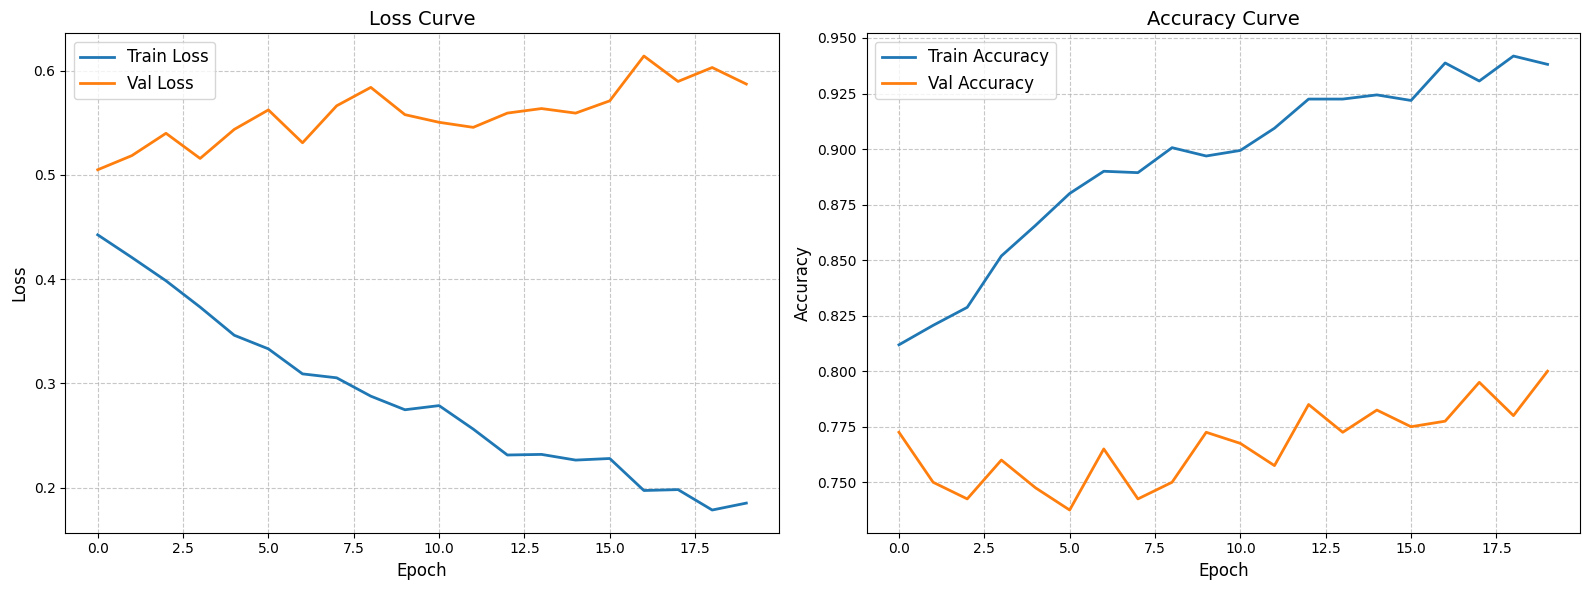

In [9]:
# 创建画布，1行2列
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- 绘制 Loss 曲线 ---
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_title('Loss Curve', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)

# --- 绘制 Accuracy 曲线 ---
axes[1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[1].plot(val_accs, label='Val Accuracy', linewidth=2)
axes[1].set_title('Accuracy Curve', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()